# Analizar Datos de Formulario

In [37]:
# PARA GOOGLE COLAB
#!pip -q install gspread
#!pip install rapidfuzz
#!pip install autocorrect
#!pip install unidecode
#!pip install pyspellchecker==0.7.2
#!pip install nltk
#!pip install wordcloud

In [38]:
# PARA GOOGLE COLAB
#import pandas as pd
#from google.colab import auth
#import google.auth
#import gspread
#import pandas as pd
#from rapidfuzz import process
#import matplotlib.pyplot as plt

In [39]:
# PARA ENTORNO LOCAL
import pandas as pd
from rapidfuzz import process
import matplotlib.pyplot as plt

In [40]:
# PARA GOOGLE COLAB
# Autenticarse y leer Google Sheets con gspread
#auth.authenticate_user()

#creds, _ = google.auth.default()
#gc = gspread.authorize(creds)

# Form de respuestas
#SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/URL_PROPIO/edit?usp=drive_link"

# Enlazando con spreadsheet
#sh = gc.open_by_url(SPREADSHEET_URL)
#ws = sh.sheet1

# Leyendo datos
#df = pd.DataFrame(ws.get_all_records())

# Eliminando columnas con información sensible
#df.drop(columns=["Dirección de correo electrónico", "Nombre completo"], inplace=True)

# FIN PARA GOOGLE COLAB

# Nombres

df = pd.read_excel("../data/C1S1-Form.xlsx")

df.head()

,Marca temporal,¿Qué carrera estudias?,¿En qué año entraste a la universidad?,¿En qué semestre de tu carrera te encuentras?,¿Tienes intención de obtener el diploma de participación en el primer curso impartido por el club? (Requiere la asistencia a un mínimo de 4 sesiones así como la presentación final de un mini proyecto.),¿Tienes conocimiento previo sobre programación?,¿Tienes conocimiento previo sobre ciencia o ingeniería de datos?,¿Cuáles son tus motivaciones para querer participar del Club de Ciencia de Datos e Ingeniería de Datos?
0,2025-08-18 13:25:55.151,Ingeniería industrial,2022,3,Sí,No,No,Enriquecer mis conocimientos
1,2025-08-18 13:37:18.353,Ing. Ciencias y sistemas.,2024,4,Sí,Sí,No,Aprender nuevas tecnologías
2,2025-08-18 13:43:17.686,Ingeniería en ciencias y sistemas,2022,6,Sí,No,No,Aprender
3,2025-08-18 13:43:30.060,Ingeniería industrial,2021,7,Sí,No,No,Es un área que me atrae y quisiera enfocar mi ...
4,2025-08-18 13:46:45.286,Ingenieria Quimica,2020,10,Sí,No,No,Es un tema importante en la actualidad y por l...


In [41]:
#Renombrando columnas
rename_dic = {
    "Marca temporal": "Timestamp",
    "¿Qué carrera estudias?": "Carrera",
    "¿En qué año entraste a la universidad?": "Carnet",
    "¿En qué semestre de tu carrera te encuentras?": "Semestre",
    "¿Tienes intención de obtener el diploma de participación en el primer curso impartido por el club? (Requiere la asistencia a un mínimo de 4 sesiones así como la presentación final de un mini proyecto.)": "Diploma",
    "¿Tienes conocimiento previo sobre programación?" : "C-Programación",
    "¿Tienes conocimiento previo sobre ciencia o ingeniería de datos?": "C-DSE",
    "¿Cuáles son tus motivaciones para querer participar del Club de Ciencia de Datos e Ingeniería de Datos?": "Motivación"
}

df = df.rename(columns=rename_dic)
df.head()


,Timestamp,Carrera,Carnet,Semestre,Diploma,C-Programación,C-DSE,Motivación
0,2025-08-18 13:25:55.151,Ingeniería industrial,2022,3,Sí,No,No,Enriquecer mis conocimientos
1,2025-08-18 13:37:18.353,Ing. Ciencias y sistemas.,2024,4,Sí,Sí,No,Aprender nuevas tecnologías
2,2025-08-18 13:43:17.686,Ingeniería en ciencias y sistemas,2022,6,Sí,No,No,Aprender
3,2025-08-18 13:43:30.060,Ingeniería industrial,2021,7,Sí,No,No,Es un área que me atrae y quisiera enfocar mi ...
4,2025-08-18 13:46:45.286,Ingenieria Quimica,2020,10,Sí,No,No,Es un tema importante en la actualidad y por l...


## Estandarizando Carrera

In [42]:
# Todo en minúsculas
df['Carrera'] = df['Carrera'].str.lower()
#df['Carrera'] = df['Carrera'].apply(lambda x: x.lower())

# Removiendo palabras inecesarias
to_remove = ["ingeniería","ingenieria","ing.", ".", "en"]

def remove_words(text, words):
    for word in words:
        text = text.replace(word, "").strip()
    return text

df['Carrera'] = df['Carrera'].apply(lambda x: remove_words(x, to_remove))

df.head()

,Timestamp,Carrera,Carnet,Semestre,Diploma,C-Programación,C-DSE,Motivación
0,2025-08-18 13:25:55.151,industrial,2022,3,Sí,No,No,Enriquecer mis conocimientos
1,2025-08-18 13:37:18.353,cicias y sistemas,2024,4,Sí,Sí,No,Aprender nuevas tecnologías
2,2025-08-18 13:43:17.686,cicias y sistemas,2022,6,Sí,No,No,Aprender
3,2025-08-18 13:43:30.060,industrial,2021,7,Sí,No,No,Es un área que me atrae y quisiera enfocar mi ...
4,2025-08-18 13:46:45.286,quimica,2020,10,Sí,No,No,Es un tema importante en la actualidad y por l...


In [43]:
# Carreras únicas
df['Carrera'].unique()

array(['industrial', 'cicias y sistemas', 'quimica', 'mecánica eléctrica',
       'química', 'eléctrica', 'sistemas', 'civil', 'maestria',
       'electronica', 'ing sistemas', 'mecánica industrial', 'mecánica',
       'licciatura  física aplicada', 'electrónica', 'ing industrial'],
      dtype=object)

In [44]:
# Corrigiendo carreras
key_words = ["industrial", "ciencias y sistemas", "química", "mecánica eléctrica", "eléctrica", "civil", "maestría", "electrónica", "mecánica industrial", "mecánica", "física"]


# Función para obtener la palabra más cercana
def asignar_keyword(texto, key_words):
    match, score, _ = process.extractOne(texto, key_words)
    return match if score > 70 else None  # se puede ajustar el umbral


df["Carrera_Ok"] = df["Carrera"].apply(lambda x: asignar_keyword(x, key_words))
df.head()


,Timestamp,Carrera,Carnet,Semestre,Diploma,C-Programación,C-DSE,Motivación,Carrera_Ok
0,2025-08-18 13:25:55.151,industrial,2022,3,Sí,No,No,Enriquecer mis conocimientos,industrial
1,2025-08-18 13:37:18.353,cicias y sistemas,2024,4,Sí,Sí,No,Aprender nuevas tecnologías,ciencias y sistemas
2,2025-08-18 13:43:17.686,cicias y sistemas,2022,6,Sí,No,No,Aprender,ciencias y sistemas
3,2025-08-18 13:43:30.060,industrial,2021,7,Sí,No,No,Es un área que me atrae y quisiera enfocar mi ...,industrial
4,2025-08-18 13:46:45.286,quimica,2020,10,Sí,No,No,Es un tema importante en la actualidad y por l...,química


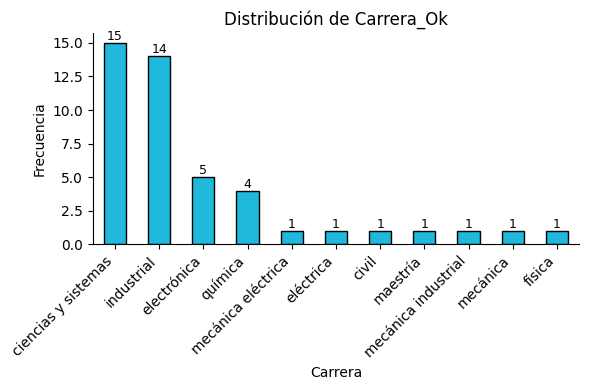

In [45]:
# Conteo y gráfico
ax = df["Carrera_Ok"].value_counts().plot.bar(
    figsize=(6,4),
    color="#20B9DB",   # club_lightblue
    edgecolor="black"
)

# Título y etiquetas
plt.title("Distribución de Carrera_Ok")
plt.xlabel("Carrera")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")

# Mostrar número arriba de cada barra
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom", fontsize=9
    )

# Quitar márgenes superior y derecho
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## Analizando Lenguaje

In [46]:
import re
from unidecode import unidecode
from spellchecker import SpellChecker
from autocorrect import Speller
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victor.borrayo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
# Limpieza básica
col_texto = "Motivación"
df_proc = df[[col_texto]].dropna().copy()

In [49]:
# Pasar a minúsculas
df_proc["texto_lower"] = df_proc[col_texto].astype(str).str.lower()

In [50]:
# Corrección ortográfica en español
spell = Speller(lang='es')
df_proc["texto_corr"] = df_proc["texto_lower"].apply(spell)
df_proc[["texto_lower", "texto_corr"]].head(10)

,texto_lower,texto_corr
0,enriquecer mis conocimientos,enriquecer mis conocimientos
1,aprender nuevas tecnologías,aprender nuevas tecnologías
2,aprender,aprender
3,es un área que me atrae y quisiera enfocar mi ...,es un área que me atrae y quisiera enfocar mi ...
4,es un tema importante en la actualidad y por l...,es un tema importante en la actualidad y por l...
5,aprender mas,aprender mas
6,"aprendizaje, aprender cosas nuevas.\n","aprendizaje, aprender cosas nuevas.\n"
7,quiero aprender de ciencia de datos,quiero aprender de ciencia de datos
8,incursionarme a la ciencia de datos en mi carr...,incursionar a la ciencia de datos en mi carrera\n
9,poder sumar conocimiento,poder sumar conocimiento


In [51]:
#Mantener símbolos útiles
pat = re.compile(r"[^a-záéíóúüñ\s]")
df_proc["texto_clean"] = df_proc["texto_corr"].str.replace(pat, " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_proc["tokens"] = df_proc["texto_clean"].str.split()
df_proc[["texto_corr", "texto_clean"]].head(10)

,texto_corr,texto_clean
0,enriquecer mis conocimientos,enriquecer mis conocimientos
1,aprender nuevas tecnologías,aprender nuevas tecnologías
2,aprender,aprender
3,es un área que me atrae y quisiera enfocar mi ...,es un área que me atrae y quisiera enfocar mi ...
4,es un tema importante en la actualidad y por l...,es un tema importante en la actualidad y por l...
5,aprender mas,aprender mas
6,"aprendizaje, aprender cosas nuevas.\n",aprendizaje aprender cosas nuevas
7,quiero aprender de ciencia de datos,quiero aprender de ciencia de datos
8,incursionar a la ciencia de datos en mi carrera\n,incursionar a la ciencia de datos en mi carrera
9,poder sumar conocimiento,poder sumar conocimiento


In [52]:
# Eliminando stopwords
stop_es = set(stopwords.words('spanish'))
df_proc["tokens_nostop"] = df_proc["tokens"].apply(lambda toks: [t for t in toks if t not in stop_es and len(t) > 2])
df_proc[["texto_clean", "tokens_nostop"]].head(10)

,texto_clean,tokens_nostop
0,enriquecer mis conocimientos,"[enriquecer, conocimientos]"
1,aprender nuevas tecnologías,"[aprender, nuevas, tecnologías]"
2,aprender,[aprender]
3,es un área que me atrae y quisiera enfocar mi ...,"[área, atrae, quisiera, enfocar, carrera]"
4,es un tema importante en la actualidad y por l...,"[tema, importante, actualidad, ingeniería, seg..."
5,aprender mas,"[aprender, mas]"
6,aprendizaje aprender cosas nuevas,"[aprendizaje, aprender, cosas, nuevas]"
7,quiero aprender de ciencia de datos,"[quiero, aprender, ciencia, datos]"
8,incursionar a la ciencia de datos en mi carrera,"[incursionar, ciencia, datos, carrera]"
9,poder sumar conocimiento,"[poder, sumar, conocimiento]"


In [53]:
# Creando Corpus
corpus = " ".join([" ".join(toks) for toks in df_proc["tokens_nostop"]])
corpus

'enriquecer conocimientos aprender nuevas tecnologías aprender área atrae quisiera enfocar carrera tema importante actualidad ingeniería seguí conocimiento tema ende ver publicación motivacion aprender nuevos temas aprender mas aprendizaje aprender cosas nuevas quiero aprender ciencia datos incursionar ciencia datos carrera poder sumar conocimiento aprender ciencia datos aprender aplicar ciencia datos empleo actual aprender tema aprender programación curiosidad aprender nuevo desarrollar habilidades datos puedan servir futuro rama favorita sistemas datos recurso mas preciado sistemas buen manejo permite analizar mejores soluciones software telecomunicaciones actualizarse interesa aprender nuevas herramientas manejo datos gustaría aprender tema lograr aplicarlo nivel profesional propio proyecto quiero ver cómo predecir datos aprender nuevos conocimientos poder aprender nuevas habilidades sobresalir campo laboral reforzar conocimientos aspectos nuevos recibir consejos profesionales área 

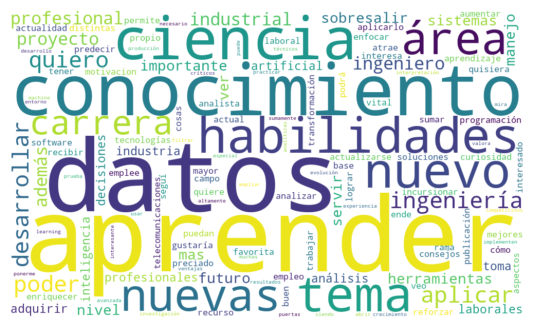

In [54]:
# Wordcloud
from wordcloud import WordCloud

wc = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    collocations=False
).generate(corpus)

plt.figure(figsize=(8, 4))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#plt.title("Nube de palabras — Motivación")
plt.show()

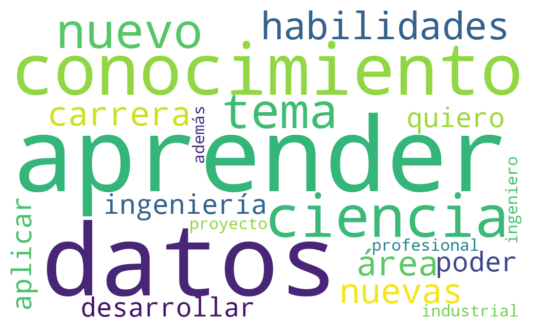

In [55]:
# Nube de palabras con las primeras 20 palabras más comunes
wc_20 = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    max_words=20,
    collocations=False
).generate(corpus)
plt.figure(figsize=(8, 4))
plt.imshow(wc_20, interpolation="bilinear")
plt.axis("off")
#plt.title("Nube de palabras — Motivación (Top 20)")
plt.show()